Created: 26-05-2022, Last-Updated: 31-05-2022
# Stochastic models and optimization - Bandits - Problem set 1
## Student: Philine Meyjohann
In this problem your task will be to reproduce a figure from an article by Chapelle and Li (2011) “An
Empirical Evaluation of Thompson Sampling”. Note that you don’t need to read the whole article,
pages 1 to 3 will suffice.

The figure that you will have to reproduce is Figure 1 (partially). The Bernoulli bandit problem for
this figure has K arms where the best arm has a reward probability of $0.5$ and the $K−1$ other arms
have a probability of $0.5−\epsilon$. Figure 1 displays four different computational experiments where UCB
and Thompson sampling algorithms are applied in Bernoulli bandits with different $K$ and $\epsilon$ parameters:
$K \in \{10, 100\}$ and $\epsilon \in \{0.02, 0.1\}$. You should replicate only the condition with $K = 10$ and $\epsilon = 0.1$ to reduce the amount of computation.

You will have to program a UCB algorithm tuned for a Bernoulli bandit problem and a Thompson
sampling algorithm. You will also compute an asymptotic lower bound for a Bernoulli problem (hint:
there is an exact formula for computing KL divergence between two Bernoulli distributions). You
should follow the paper for exact formulations of the algorithms.

To be clear, you should produce a figure with cumulative regret on y-axis and log-transformed steps/trials
on x-axis. You will need to simulate agents for 1000000 trials to get good trends on $K = 10$ and run at
least 10 simulations to get more reliable estimates for each algorithm.

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random

### UCB
There are various variants of the UCB algorithm, but they all have in common that the confidence parameter should increase over time. Chapelle and Li (2011) choose the arm for which the following upper confidence bound is maximum:
$$\frac{k}{m}+\sqrt{\frac{2 \frac{k}{m} \log \frac{1}{\delta}}{m}}+\frac{2 \log \frac{1}{\delta}}{m}, \quad \delta=\sqrt{\frac{1}{t}}$$
where $m$ is the number of times the arm has been selected and $k$ its total reward. This is a tight upper confidence bound derived from Chernoff’s bound.

In [2]:
# define UCB1 algorithm
def ucb(K, epsilon, T):
    reward_array = [0.5] + [0.5-epsilon]*(K-1)
    Q_estimates = np.zeros((T,K))
    U_estimates = np.zeros((T,K))
    UCB = np.zeros((T,K))
    regret = np.zeros(T)

    # initialize action values
    m = np.ones(K) # number of times the arm has been selected
    k = np.zeros(K) # total reward of each arm
    for i in range(K):
        k[i] += np.random.binomial(1, p=reward_array[i])

    # pick bandit with highest upper confidence index at each point in time
    for t in range(1, T):
        for i in range(K):
            if t%100 == 0: # update parameters every 100 iterations as per paper
                delta = math.sqrt(1/t)
                Q_estimates[t,i] = k[i]/m[i]
                U_estimates[t,i] = math.sqrt((2*k[i]/m[i]*np.log(1/delta))/m[i]) + (2*np.log(1/delta))/m[i]
                UCB[t,i] = Q_estimates[t,i] + U_estimates[t,i]
            else:
                UCB[t,i] = UCB[t-1,i]
        opt_arm = np.argmax(UCB[t,:])
        reward = np.random.binomial(1, p=reward_array[opt_arm])
        regret[t] = regret[t-1] + (0.5 - reward_array[opt_arm])
        m[opt_arm] += 1
        k[opt_arm] += reward
        
    return regret

In [3]:
regret_ucb = ucb(K=10, epsilon=0.1, T=1000000)
regret_ucb

array([  0.,   0.,   0., ..., 940., 940., 940.])

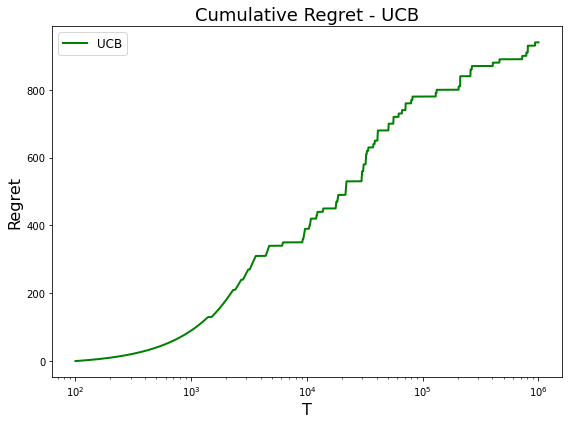

In [4]:
# plot the cumulative regret - single simulation
T = 1000000

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

plt.title("Cumulative Regret - UCB", fontsize=18)
plt.plot(range(100,T), regret_ucb[100:], color="green", label="UCB", linewidth=2)
plt.legend(loc="upper left", fontsize=12)
plt.xscale('log')
plt.xlabel('T', fontsize=16)
plt.ylabel('Regret', fontsize=16)

plt.show()

### Thompson sampling

I replicate the Thompson sampling algorithm as specified in the paper:
<div>
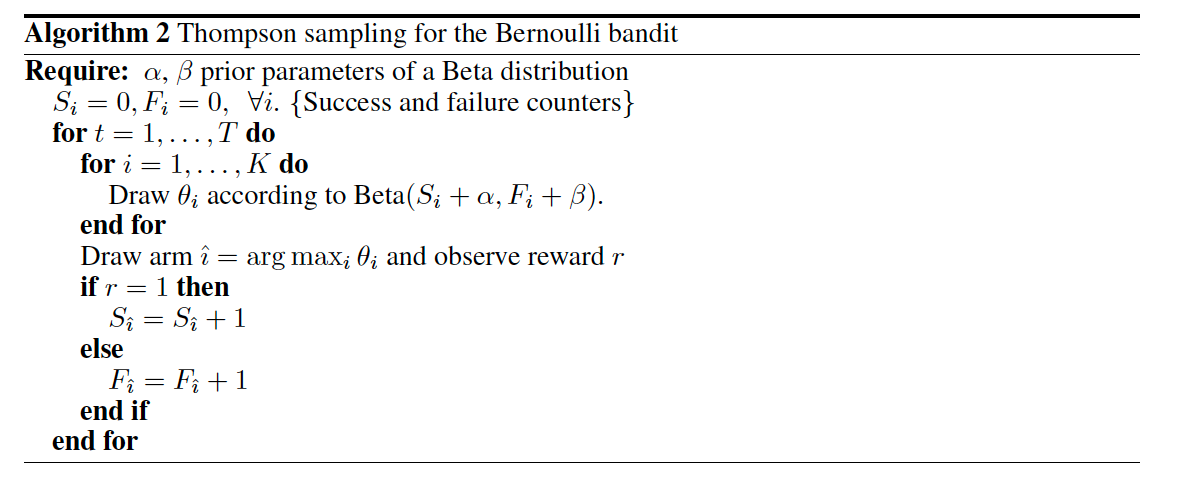
</div>

In [5]:
# define Thompson sampling algorithm
def thompson(alpha, beta, K, epsilon, T):
    reward_array = [0.5] + [0.5-epsilon]*(K-1)
    regret = np.zeros(T)
    success_count = np.zeros(K)
    failure_count = np.zeros(K)
    theta = np.zeros((T,K))

    for t in range(T):
        for i in range(K):
            if t % 100 == 0: # update parameters every 100 iterations as per paper
                theta[t,i] = np.random.beta(success_count[i]+alpha, failure_count[i]+beta)
            else:
                theta[t,i] = theta[t-1,i]
        opt_arm = np.argmax(theta[t,:])
        reward = np.random.binomial(1, p=reward_array[opt_arm])
        regret[t] = regret[t-1] + (0.5 - reward_array[opt_arm])
        if reward==1:
            success_count[opt_arm] += 1
        else:
            failure_count[opt_arm] += 1
    
    return regret

In [6]:
regret_ts = thompson(alpha=1, beta=1, K=10, epsilon=0.1, T=1000000)
regret_ts

array([1.0e-01, 2.0e-01, 3.0e-01, ..., 4.3e+02, 4.3e+02, 4.3e+02])

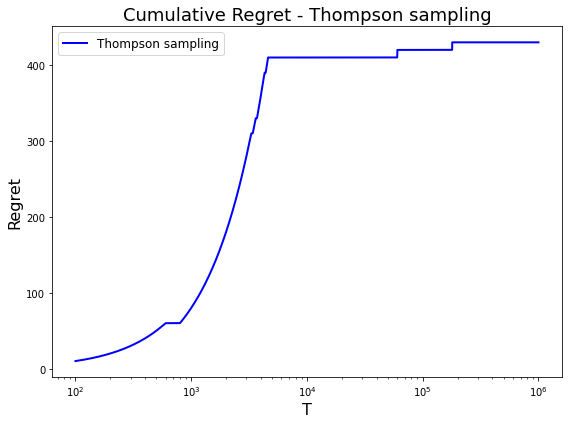

In [7]:
# plot the cumulative regret - single simulation
T = 1000000

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

plt.title("Cumulative Regret - Thompson sampling", fontsize=18)
plt.plot(range(100,T), regret_ts[100:], color="blue", label="Thompson sampling", linewidth=2)
plt.legend(loc="upper left", fontsize=12)
plt.xscale('log')
plt.xlabel('T', fontsize=16)
plt.ylabel('Regret', fontsize=16)

plt.show()

### Asymptotic lower bound
Chapelle and Li (2011) establish the asymptotic lower bound for the regret of a bandit algorithm as follows:
$$
R(T) \geq \log (T)\left[\sum_{i=1}^{K} \frac{p^{*}-p_{i}}{D\left(p_{i} \| p^{*}\right)}+o(1)\right]
$$
where $p_{i}$ is the reward probability of the $i$-th arm, $p^{*}=\max p_{i}$ and $D$ is the Kullback-Leibler divergence. This lower bound is logarithmic in $T$ with a constant depending on the $p_{i}$ values.

In [8]:
def KL(p,p_max,i):
    D = p[i]*np.log(p[i]/p_max) + (1-p[i])*np.log((1-p[i])/(1-p_max))
    return D

In [9]:
def asymptotic_lower_bound(K, epsilon, T):
    p = [0.5] + [0.5-epsilon]*(K-1)
    p_max = np.max(p)
    lower_bound = np.zeros(T)

    constant=0 # initialise constant
    for i in range(K):
        if p[i] != p_max:
            constant += (p_max-p[i])/KL(p,p_max,i)
            
    for t in range(0,T):
        if t == 0:
            lower_bound[t] = 0
        else:
            lower_bound[t] = np.log(t)*(constant)
            
    return lower_bound
    

In [10]:
# shift lower bound such that the red curve passes through the lower left-hand corner of the plot
lower_bound = asymptotic_lower_bound(K=10, epsilon=0.1, T=1000000)
lower_bound_shifted = lower_bound[100:]
lower_bound_shifted = lower_bound_shifted - lower_bound_shifted[0]

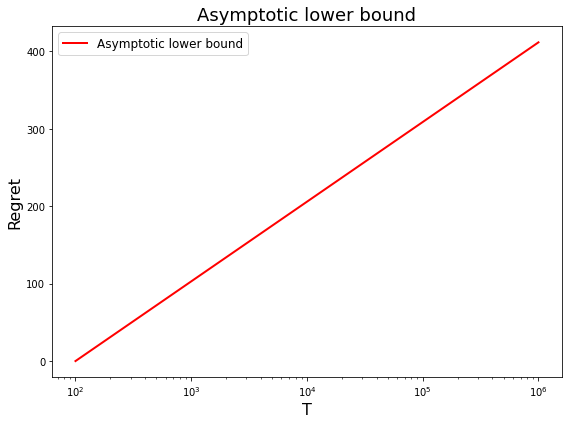

In [11]:
# plot the cumulative regret - single simulation
T = 1000000

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True

plt.title("Asymptotic lower bound", fontsize=18)
plt.plot(range(100,T), lower_bound_shifted, color="red", label="Asymptotic lower bound", linewidth=2)
plt.legend(loc="upper left", fontsize=12)
plt.xscale('log')
plt.xlabel('T', fontsize=16)
plt.ylabel('Regret', fontsize=16)

plt.show()

## Run simulations
I aim to replicate the following graph from Chapelle and Li (2011):
<div>
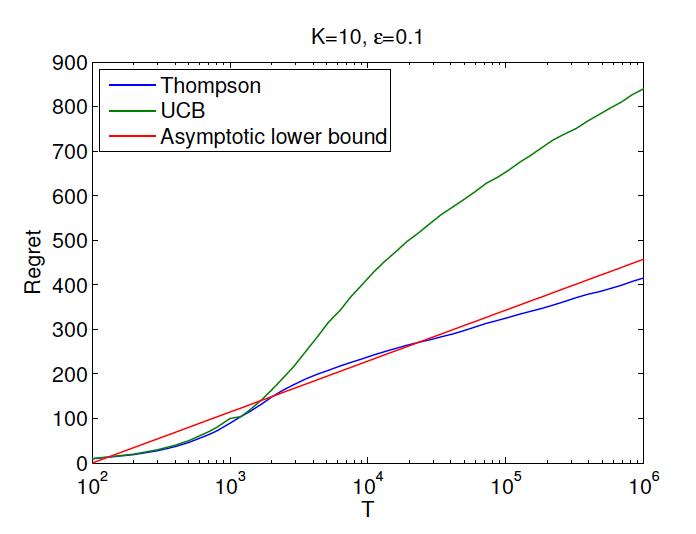
</div>

In [12]:
def compare_bandit_algorithms(alpha, beta, K, epsilon, T, no_simulations):
    # runs n simulations for each algorithm and compares the output
    regret_ucb_sim = np.zeros((T, no_simulations))
    regret_ts_sim = np.zeros((T, no_simulations))
    
    for n in range(no_simulations):
        regret_ucb = ucb(K, epsilon, T)
        regret_ucb_sim[:,n] = regret_ucb
        
        regret_ts = thompson(alpha, beta, K, epsilon, T)
        regret_ts_sim[:,n] = regret_ts
        
        lower_bound = asymptotic_lower_bound(K, epsilon, T)
        
        # shift lower bound such that the red curve passes through the lower left-hand corner of the plot
        lower_bound_shifted = lower_bound[100:]
        lower_bound_shifted = lower_bound_shifted - lower_bound_shifted[0]
  
    avg_regret_ucb = np.mean(regret_ucb_sim, axis=1)
    avg_regret_ts = np.mean(regret_ts_sim, axis=1)
    
    # plot the cumulative regret
    plt.rcParams["figure.figsize"] = [8,6]
    plt.rcParams["figure.autolayout"] = True

    plt.title("$K=10$, $\epsilon=0.1$", fontsize=18)
    plt.plot(range(100,T), avg_regret_ucb[100:], color="green", label="UCB", linewidth=1)
    plt.plot(range(100,T), avg_regret_ts[100:], color="blue", label="Thompson", linewidth=1)
    plt.plot(range(100,T), lower_bound_shifted, color="red", label="Asymptotic lower bound", linewidth=1)
    plt.legend(loc="upper left", fontsize=12)
    plt.xscale('log')
    plt.xlabel('T', fontsize=16)
    plt.ylabel('Regret', fontsize=16)

    return plt.show

CPU times: user 3min 49s, sys: 2.21 s, total: 3min 52s
Wall time: 3min 51s


<function matplotlib.pyplot.show(close=None, block=None)>

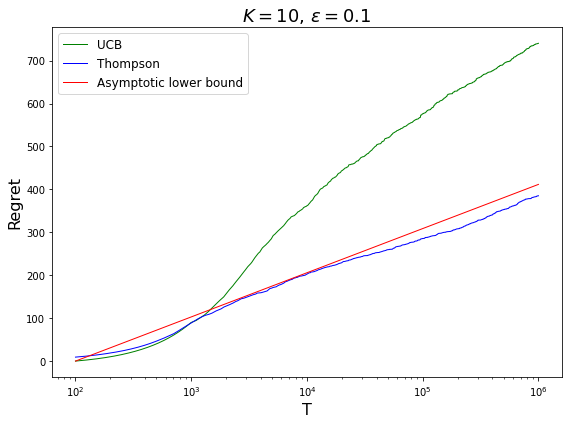

In [14]:
%%time
compare_bandit_algorithms(alpha=1, beta=1, K=10, epsilon=0.1, T=1000000, no_simulations=25)